<p align="center">
<img src="https://www.uao.edu.co/wp-content/uploads/2024/12/uao-logo-2-04.webp" width=15%>


<h2>UNIVERSIDAD AUTÓNOMA DE OCCIDENTE</strong></h2>
<h3>03/06/2025 CALI - COLOMBIA</strong></h3>
<h3><strong>MAESTRIA EN INTELIGENCIA ARTIFICIAL Y CIENCIA DE DATOS</strong></h3>
<h3><strong>ETL (EXTRACT, TRANSFORM AND LOAD)</strong></h3>
<h3><strong>EJERCICIO EN CLASE 2 </strong> TRANSFORMACIONES</h3>
<h3><strong>*   Profesor:</strong> JAVIER ALEJANDRO VERGARA ZORRILLA</h3>
<h3><strong>*   Alumno:</strong> Yoniliman Galvis Aguirre</h3>
<h3><strong>*   Código:</strong> 22500214 </h3>

# EJERCICIO ETL #2

## Contexto
Este conjunto de datos proviene de una empresa de comercio electrónico, que contiene diversa información sobre los productos disponibles en la tienda.

## Ejercicio
*   Realiza todas las transformaciones necesarias para obtener un conjunto de datos limpio con las características requeridas para entrenar un modelo de aprendizaje automático que prediga si un producto es nuevo o usado.

*   Una característica es una columna con información importante o relevante para resolver el problema.

*   Toma en cuenta todas las consideraciones y supuestos que necesites. En la carpeta de Google Drive puedes encontrar el archivo data_clean.csv, el cual puedes usar como ejemplo de salida.

*   Realiza todo el Análisis Exploratorio de Datos (EDA) que consideres necesario, utiliza gráficos como apoyo y aplica todas las transformaciones requeridas.

---
# Verificar Kernel
Verificamos si el ambiente jupyter esta ejecutando el kernel en el entorno correcto, el resultado de las dos rutas debe coincidir, de lo contrario se debe de cambiar el kernel del jupyter notebook, una opcion es correr el enviroment desde poetry, en la terminal ejecute:

```bash
poetry run jupyter notebook
```
esto abrirá una version web de jupyter, en otro caso cambie el kernel y use los venv disponibles

Si el notebook esta ejecutando un kernel diferente a la carpeta del proyecto cuando instale librerías se presentarán fallas en la ejecucion del código del notebook

In [1]:
# Este chunk permite verificar si el entorno de VStudio y la carpeta de pyenv están sincronizadas, se cargan librerias canónicas de python
# Ejecuta tambien un comando sobre el bash (cmd en windows) para obtener el entorno de la carpeta de trabajo

import subprocess
import shutil

# Ejecutar el comando de poetry desde Python
result = subprocess.run(['poetry', 'env', 'info', '--path'], capture_output=True, text=True)

# Obtener la ruta del entorno virtual
env_path = result.stdout.strip()

# Obtener la ruta del ejecutable de Python activo
python_path = shutil.which("python")

print(f"El entorno virtual activo de poetry está en: {env_path}")
print(f"El entorno virtual activo del kernel en el notebook está en: {python_path}")

El entorno virtual activo de poetry está en: /home/ygalvis/Documents/Study/ETL_Ejercicio2/.venv
El entorno virtual activo del kernel en el notebook está en: /home/ygalvis/Documents/Study/ETL_Ejercicio2/.venv/bin/python


---
# DESARROLLO DEL EJERCICIO

## Preparación del sistema

In [ ]:
# Cargar librerias para desarrollo del ejercicio
import pandas as pd                 # Para manejo de dataframes
import jsonlines                    # Para manejo de archivo json lineal
from tqdm import tqdm               # Para la barrita (percentfill) de proceso
import numpy as np                  # Para el procesamiento de numeros
import tensorflow as tf             # Para detectar GPU la que sea....
#import torch                       # Por si hay envidia.., no es para mi... a mi no me da envidia....
import matplotlib.pyplot as plt     # Para hacer graficos
import plotly.graph_objects as go   # Graficos
import re                           # para verificar un texto segun un patron determiando

#crear variable para separar la impresion de resultados de las operaciones del procesanmiento anteriores
separador = "\n<--" + "-" * 100 + "-->\n"

### Check GPU
Verificar la existencia de una GPU compatible

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(separador,"GPUs compatibles detectadas:",separador)
    for gpu in gpus:
        print(separador,gpu,separador)
    # Configuramos TensorFlow para que use la primera GPU encontrada
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    print(separador,"TensorFlow usará la primera GPU disponible.",separador)
else:
    print(separador,"Ups... No se detectó ninguna GPU, nos fuímos con la CPU!.",separador)


<-------------------------------------------------------------------------------------------------------->
 Ups... No se detectó ninguna GPU, nos fuímos con la CPU!. 
<-------------------------------------------------------------------------------------------------------->



2025-03-07 23:27:29.811221: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Cargar Dataset
Vamos a usar la librería jsonlines ya que conocemos que el dataset es tipo "***.jsonlines***"

### Funciones
Vamos a definir la funcion para tomar los datos del dataset y llevarlos a un dataframe.

In [3]:
# Leer el archivo Json lineal y hacer la prelimpieza
def leer_jsonl(ruta_archivo, ruta_exportar):
    """
    *   paso 1 Leemos un archivo JSONL y lo cargamos en un DataFrame.
    *   paso 2 Eliminamos columnas con valores nulos, listas vacías ([]), o diccionarios vacíos ({}).
    *   paso 3 Exportamos los encabezados y la primera fila a un archivo de texto para analisis de tablas grandes con muchas columnas.

    Args:
        ruta_archivo (str): En donde encontramos el archivo JSONL.
        ruta_exportar (str): En donde queremos colocar el archivo de texto donde se exportarán los encabezados y la primera fila para analisis posterior.

    Returns:
        pd.DataFrame: Devolvemos un DataFrame limpio con las columnas vacías eliminadas si las encuentra en el json.
    """
    # iniciao dataframe
    data = []
    
    # Intentar subir los datos
    try:
        with jsonlines.open(ruta_archivo) as reader:
            for obj in tqdm(reader, desc="*Proceso:* Leyendo líneas del archivo JSONL"):
                data.append(obj)
    
    # Manejo de errores que siempre puede haber!
    except FileNotFoundError:
        print(separador,"*Error 1:* No se encontró el archivo. Verifica la entrada de la ruta del archivo.",separador)
        return pd.DataFrame()
    except jsonlines.InvalidLineError as e:
        print(separador,f"*Error 2:* encontramos fallas al leer una línea del archivo. Revisa el JSON: {e}",separador)
        return pd.DataFrame()
    except Exception as e:
        print(separador,f"*Error 3:* tenemos un problema inesperado ó no reconocido: {e}",separador)
        return pd.DataFrame()

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    if df.empty:
        print(separador,"*Advertencia:* El archivo JSONL está vacío o no pudimos cargarlo correctamente.",separador)
        return df

    # Exportar encabezados y primera fila alineados de forma vertical para mejor reconocimiento
    with open(ruta_exportar, "w", encoding="utf-8") as f:
        columnas = df.columns.tolist()
        valores = df.iloc[0].astype(str).tolist() if not df.empty else [""] * len(columnas)
        max_len = max(len(col) for col in columnas)

        f.write("Encabezado y primer fila:\n\n")
        for col, val in zip(columnas, valores):
            f.write(f"{col.rjust(max_len)} : {val}\n")

    print(separador,f"*Info:* El archivo ha sido exportado a: {ruta_exportar}",separador)
    return df

### Cargar Leer datos
Vamos a tomar los archiv

In [4]:
ruta_archivo = 'Dataset/MLA_100k.jsonlines'
ruta_exportar = 'Dataset/header_firstrow.txt'
df = leer_jsonl(ruta_archivo, ruta_exportar)

# Presntar todas las columnas en formato vertical con las primera filas
pd.options.display.max_rows = None
print(separador,df.head(1).T,separador)

*Proceso:* Leyendo líneas del archivo JSONL: 0it [00:00, ?it/s]

*Proceso:* Leyendo líneas del archivo JSONL: 100000it [00:04, 21035.79it/s]



<-------------------------------------------------------------------------------------------------------->
 *Info:* El archivo ha sido exportado a: Dataset/header_firstrow.txt 
<-------------------------------------------------------------------------------------------------------->


<-------------------------------------------------------------------------------------------------------->
                                                                                   0
seller_address                    {'comment': '', 'longitude': -58.3986709, 'id'...
warranty                                                                       None
sub_status                                                                       []
condition                                                                       new
seller_contact                                                                 None
deal_ids                                                                         []
base_price       

---
## Procesamiento de Datos
Vamos a procesar el dataframe, porque pueden haber columnas tipo diccionario (dict: {}) ó tipo lista (list: []), eso significa que esa columna posiblemente contiene un conjunto de columnas mas ó sea están anidadas

### Definir funciones

In [44]:
# DEfinimos una funcion para tomar una columna con estancias anidadas y las expandimos (descomponemos) 
# y obtenemos un dataframe diferente al de entrada vamos a tratar de no modificar el dataframe original.
# Vamos a usar tqdm de pandas para generar un percentfill por para que el usuario pueda percibir el progreso

# Activar el progress_apply de tqdm
tqdm.pandas()

def exploit_column(df, columna):
    """
    *   Vamos a expandir una única columna del DataFrame sin modificar el dataframe (df) original.
    *   Si la columna es de tipo lista (list: []) o diccionario (dict: {}) entonces se expande y retornamos
        un DataFrame con las columnas expandidas, donde para reconocer su origen inicial a nueva columna la nombraremos como <columna original>_<clave>.
    *   Si la columna no es una lista ni un diccionario entonces vamos a retornar un DataFrame que contiene
        únicamente la Serie original y conservando el encabezado original de la columna.
    
    Args:
        df (pd.DataFrame): Nombre del DataFrame de entrada.
        columna (str): Nombre de la columna a procesar en del Dataframe de entradas.
    
    Returns:
        pd.DataFrame: Si es lista o diccionario entonces se expande y se retorna un DataFrame con las columnas expandidas;
                      si no es lista ni diccionario no se expande, se retorna un DataFrame con la columna original y se conserva el encabezado.
    """
    if columna not in df.columns:
        print(separador,f"La columna ingresada: '{columna}', no existe en el DataFrame. Corrija el nombre antes de volver a intentar",separador)
        return pd.DataFrame()  # Retorna DataFrame vacío

    # Vamos a trabajar sobre una copia de la columna para no modificar el dataframe original
    serie = df[columna].copy()
    non_null = serie.dropna()
    
    if non_null.empty:
        print(separador,f"La columna ingresada: '{columna}', está vacía.",separador)
        return #serie.to_frame()  # Retorna DataFrame con la columna (vacía)

    primer_valor = non_null.iloc[0]
    
    # Caso 1: La columna es una lista
    if isinstance(primer_valor, list):
        # Reemplazar listas vacías por np.nan
        serie = serie.progress_apply(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)
        
        # Verificar si, en las celdas no nulas, todos los elementos de la lista son diccionarios
        def is_list_of_dicts(x):
            if isinstance(x, list):
                return all(isinstance(item, dict) for item in x)
            return False
        
        # Si todas las celdas (no nulas) cumplen el patrón, fusionamos los diccionarios de cada celda
        if non_null.apply(is_list_of_dicts).all():
            def merge_dicts(dict_list):
                merged = {}
                for d in dict_list:
                    for k, v in d.items():
                        # Acumula los valores en una lista
                        merged.setdefault(k, []).append(v)
                # Convierte la lista en una cadena separada por comas
                return {k: ", ".join(map(str, v)) for k, v in merged.items()}
            # Aplicar fusión a cada celda (saltando NaN)
            serie = serie.progress_apply(lambda x: merge_dicts(x) if isinstance(x, list) else x)
            # Expandir el diccionario resultante
            df_expanded = pd.json_normalize(serie, sep="_")
            df_expanded = df_expanded.rename(columns=lambda c: f"{columna}_{c}")
            df_expanded.dropna(axis=1, how="all", inplace=True)
            return df_expanded
        else:
            # Caso alternativo: se explota la lista si no es exclusivamente de diccionarios
            if serie.progress_apply(lambda x: isinstance(x, list)).any():
                serie = serie.explode()
            if serie.progress_apply(lambda x: isinstance(x, dict)).any():
                df_expanded = pd.json_normalize(serie, sep="_")
                df_expanded = df_expanded.rename(columns=lambda c: f"{columna}_{c}")
                df_expanded.dropna(axis=1, how="all", inplace=True)
                return df_expanded
            else:
                return serie.to_frame()

    # Caso 2: La columna es un diccionario
    elif isinstance(primer_valor, dict):
        serie = serie.progress_apply(lambda x: np.nan if x is None or (isinstance(x, dict) and len(x) == 0) else x)
        if serie.notna().any() and serie.progress_apply(lambda x: isinstance(x, dict)).any():
            df_expanded = pd.json_normalize(serie, sep="_")
            df_expanded = df_expanded.rename(columns=lambda c: f"{columna}_{c}")
            df_expanded.dropna(axis=1, how="all", inplace=True)
            return df_expanded
        else:
            return serie.to_frame()

    # Caso 3: La columna no es ni lista ni diccionario
    else:
        # Si la columna es un string que cumple el patrón "número x número", convertirla a tupla de enteros.
        patron = re.compile(r'^\d+x\d+$')
        if isinstance(primer_valor, str) and patron.match(primer_valor):
            serie = serie.progress_apply(lambda x: tuple(map(int, x.split("x"))) if pd.notnull(x) else x)
            return serie.to_frame()
        else:
            # Retornar la columna original envuelta en un DataFrame
            return serie.to_frame()

In [45]:
# Esta funcion recibe un dataframe y una lista de columnas que queremos expandir, si no ingresamos la lista de columnas 
# se procesarán todas las columnas existentes en el dataframe y si encuentra columnas con anidadas las expandirá,
# la salida es un dataframe diferente al de entrada, incluirá las columnas originales que no estaban anidadas
# y todas las que antes estaban anidadas pero expandidas y el encabezado incluirá el nombre de la columna original
# esto con el fin de poder rastrear la columna hasta el origen en el dataframe original

def exploit_df(df, lista_columnas=None):
    """
    *   Utilizando la función llamada 'exploit_column' procesaremos, columna a columna, el DataFrame de entrada
        luego concatenamos horizontalmente los resultados omitiendo las columnas resultantes que estén completamente vacías.
    
    *   Si no se especifica 'lista_columnas', se procesan todas las columnas.
    
    *   Se concerva el Dataframe de entrada y en el DataFrame final de salida se reemplazan todos los valores None por np.nan.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada, al que queremos expandir si es necesario.
        lista_columnas (list, optional): Lista de nombres de columna a expandir si deseamos obtener solo las columnas a expandir.
        
    Returns:
        pd.DataFrame: Un nuevo DataFrame con las columnas procesadas, 
                      omitiendo las completamente vacías y con None reemplazados por np.nan.
    """
    if lista_columnas is None:
        lista_columnas = df.columns.tolist()

    resultados = []
    for col in lista_columnas:
        # Paso 1: llamando a la función 'exploit_column' (previamente definida)
        res = exploit_column(df, col)
        if res is not None:
            # Paso 2: Eliminando columnas que estén completamente vacías (solo NaN)
            res_filtrado = res.dropna(axis=1, how="all")
            if not res_filtrado.empty:
                resultados.append(res_filtrado.reset_index(drop=True))
    
    if resultados:
        df_resultante = pd.concat(resultados, axis=1)
        # Reemplazamos los None por np.nan en el DataFrame final
        df_resultante = df_resultante.replace({None: np.nan})
        return df_resultante
    else:
        return pd.DataFrame()

### Expansion del Dataframe
Usando las funciones: 'exploit_column' y 'exploit_df' vamos a pasarle el Dataframe donde está la informacion que cargamos del "***.jsonlines***".
Esto nos va ha generar un nuevo Dataframe sin columnas anidadas, sin columnas vacias y con valores nulos como np.nan

Vamos a desplegar el dataframe expandido mostrando el encabezado y la primera fila en formato vertical para facilitar la visualizacion y comprension

In [46]:
# Procesar todas las columnas del JSON Dataframe
df_exploit= exploit_df(df)

100%|██████████| 100000/100000 [00:00<00:00, 158706.83it/s]



<-------------------------------------------------------------------------------------------------------->
 La columna ingresada: 'differential_pricing', está vacía. 
<-------------------------------------------------------------------------------------------------------->


<-------------------------------------------------------------------------------------------------------->
 La columna ingresada: 'subtitle', está vacía. 
<-------------------------------------------------------------------------------------------------------->



100%|██████████| 100000/100000 [00:00<00:00, 1553722.14it/s]


Como se observa se eliminaron 2 columnas que estaban vacias: [***differential_pricing***, ***subtitle***]

## Análisis Exploratorio
*   "***df_exploit***": es el Dataframe expandido listo para seguir el análisis.
*   Vamos a definir las funciones que sean necesarias
*   Vamos a generar un resumen donde podamos ver el tamaño del dataset cantidad de columnas y el numero de filas.
*   Analizar si se tienen faltantes
*   Estadistica descriptiva básica.
*   Ver la distribucion de las variables
*   Analizar si hay correlaciones

In [47]:
# Funcion para mostrar los tipos de columnas de un dataframe pero organizado de forma mas intuitiva
def types_column(df):
    """
    Vamos a presentar en un DataFrame cada tipo de dato de la lista de columnas del DataFrame original organizado por tipo.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada.
        
    Returns:
        pd.DataFrame: DataFrame con dos columnas: 'tipo' y 'columnas'.
                    'tipo' indica el tipo de dato y 'columnas' es una lista de nombres.
    """
    num_filas, num_columnas = df.shape
    print(separador,f"El DataFrame tiene {num_filas} filas y {num_columnas} columnas.",separador)
    print(f"informacion. {df.info()}",separador)
    
    df_tipos = (
        df.dtypes
          .reset_index()
          .rename(columns={'index': 'columna', 0: 'tipo'})
          .groupby('tipo')['columna']
          .apply(list)
          .reset_index()
          .rename(columns={'columna': 'columnas'})
    )
    print(separador,df_tipos,separador)
    return df_tipos

In [48]:
# Vamos a tomar un DataFrame y presentar un gráfico de barras con el porcentaje de valores "missing" por columna:
def plot_missing(df, figsize=(12, 6), color='skyblue', rotation=45, title="Porcentaje de valores missing por columna"):
    """
    Generamos un gráfico de barras que muestra el porcentaje de valores missing (NaN) en cada columna del DataFrame.

    Args:
        df (pd.DataFrame): DataFrame que queremos analizar.
        figsize (tuple, optional): Definimos el Tamaño de la figura (ancho, alto). Por defecto (12, 6).
        color (str, optional): Definimos el color de las barras. Por defecto 'skyblue'.
        rotation (int, optional): Rotar las etiquetas del eje x. Por defecto 45.
        title (str, optional): EL título del gráfico. Por defecto "% de valores missing por columna".

    Returns:
        None: Mostramos el gráfico.
    """
    # Calculamos el porcentaje de los valores missing por cada columna
    missing_percent = df.isnull().mean() * 100

    # Ordenamos las columnas dependiendo del porcentaje de missing (de mayor a menor)
    missing_percent = missing_percent.sort_values(ascending=False)

    # Crear el gráfico
    plt.figure(figsize=figsize)
    missing_percent.plot(kind='bar', color=color)
    plt.ylabel("% de valores missing")
    plt.xlabel("Columnas")
    plt.title(title)
    plt.xticks(rotation=rotation, ha='right')
    plt.tight_layout()
    plt.show()

### Resumen General y Dimensiones
Observar el dataframe como un conjunto

In [49]:
# Ver informacion
print("DataFrame Summary:")

# guardar informacion de los encabezados por tipo de valor
df_types = types_column(df_exploit)

print("DataFrame Header:")
print(separador,df_exploit.head(1).T,separador)
print("DataFrame Tail:")
print(separador,df_exploit.tail(1).T,separador)


DataFrame Summary:

<-------------------------------------------------------------------------------------------------------->
 El DataFrame tiene 101626 filas y 106 columnas. 
<-------------------------------------------------------------------------------------------------------->

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101626 entries, 0 to 101625
Columns: 106 entries, seller_address_comment to available_quantity
dtypes: float64(9), object(97)
memory usage: 82.2+ MB
informacion. None 
<-------------------------------------------------------------------------------------------------------->


<-------------------------------------------------------------------------------------------------------->
       tipo                                           columnas
0  float64  [base_price, seller_id, price, official_store_...
1   object  [seller_address_comment, seller_address_longit... 
<--------------------------------------------------------------------------------------------

### Analisis de faltantes

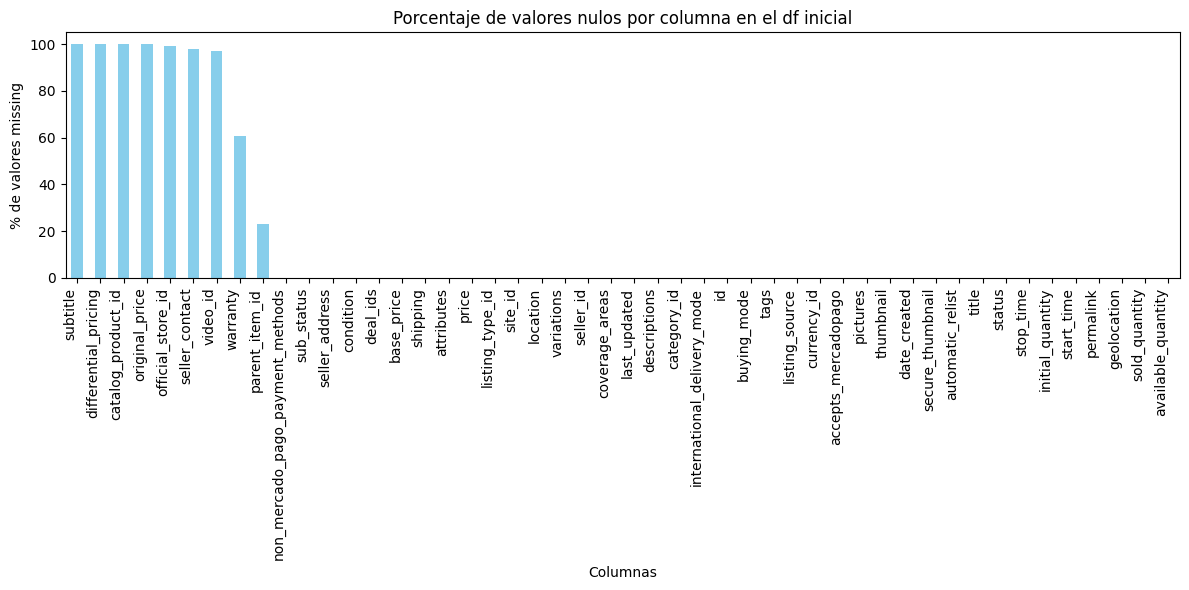

In [50]:
plot_missing(df, rotation = 90, title= "Porcentaje de valores nulos por columna en el df inicial")

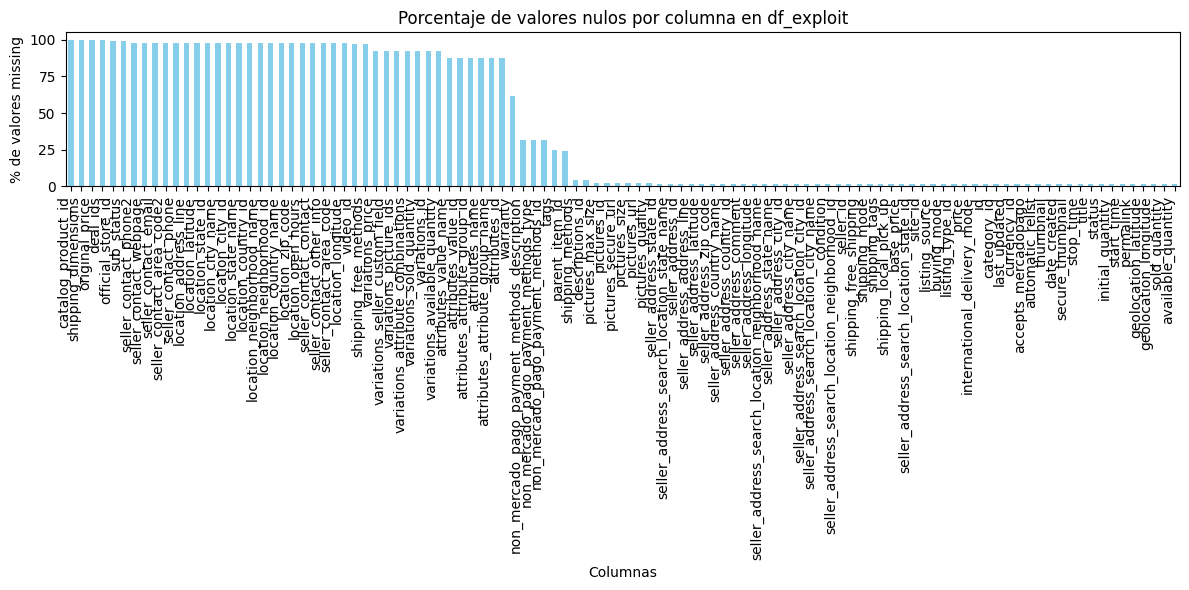

In [51]:
plot_missing(df_exploit, rotation = 90, title= "Porcentaje de valores nulos por columna en df_exploit")

### Ver columnas vacias

In [40]:
missing = df.isna().sum().sort_values(ascending=False)
vacias = missing[missing > 50]
df[vacias.index].head(10), df[vacias.index].tail(10)

(  subtitle differential_pricing  catalog_product_id  original_price  \
 0     None                 None                 NaN             NaN   
 1     None                 None                 NaN             NaN   
 2     None                 None                 NaN             NaN   
 3     None                 None                 NaN             NaN   
 4     None                 None                 NaN             NaN   
 5     None                 None                 NaN             NaN   
 6     None                 None                 NaN             NaN   
 7     None                 None                 NaN             NaN   
 8     None                 None                 NaN             NaN   
 9     None                 None                 NaN             NaN   
 
    official_store_id seller_contact     video_id            warranty  \
 0                NaN           None         None                None   
 1                NaN           None         None  NUESTRA R

In [41]:
missing = df_exploit.isna().sum().sort_values(ascending=False)
vacias = missing[missing > 50]
df_exploit[vacias.index].head(10), df_exploit[vacias.index].tail(10)

(   catalog_product_id shipping_dimensions  original_price deal_ids  \
 0                 NaN                 NaN             NaN      NaN   
 1                 NaN                 NaN             NaN      NaN   
 2                 NaN                 NaN             NaN      NaN   
 3                 NaN                 NaN             NaN      NaN   
 4                 NaN                 NaN             NaN      NaN   
 5                 NaN                 NaN             NaN      NaN   
 6                 NaN                 NaN             NaN      NaN   
 7                 NaN                 NaN             NaN      NaN   
 8                 NaN                 NaN             NaN      NaN   
 9                 NaN                 NaN             NaN      NaN   
 
   variations_seller_custom_field  official_store_id sub_status  \
 0                            NaN                NaN        NaN   
 1                            NaN                NaN        NaN   
 2              

In [ ]:
df.to_csv("Dataset/output1.csv", index=False)
df_exploit.to_csv("Dataset/output2.csv", index=False)